input 
1. tf-idf (document term matrix)
2. n_topics
3. n_iter

every docu is prob of topics
every topic is prob of words

by the idea of gibbs sampling 

1. choose k (n_topics)
2. randomly assign topic to each word in the documents 
3. go through every word and its assigned topic in each docu, and see 1. how often the topic occurs in the docu amd 2. how often the word occurs in the topic overall

其他方法
1. LSI 
2. NMF 

參考：[medium](https://medium.com/pyladies-taiwan/%E4%BB%A5-jieba-%E8%88%87-gensim-%E6%8E%A2%E7%B4%A2%E6%96%87%E6%9C%AC%E4%B8%BB%E9%A1%8C-%E4%BA%94%E6%9C%88%E5%A4%A9%E4%BA%BA%E7%94%9F%E7%84%A1%E9%99%90%E5%85%AC%E5%8F%B8%E6%AD%8C%E8%A9%9E%E5%88%86%E6%9E%90-ii-fdf5d3708662)
[youtube python](https://www.youtube.com/watch?v=NYkbqzTlW3w)

## loading data

In [286]:
from ckiptagger import data_utils, construct_dictionary, WS, POS, NER
from gensim import models, corpora
import gensim
import pandas as pd
import numpy as np
ws = WS("./data")
pos = POS("./data")

In [287]:
with open('dictionary/LDAwords.txt', 'r', encoding= 'utf-8') as f:
    data = f.readlines()
    word_dict = {}
    
    for row in data:
        try:
            (word, count) = row.strip().split()
            word_dict[word] = count
        except:
            pass

In [288]:
with open('stopwords/LDAstopwords.txt', 'r', encoding= 'utf-8') as f:
    data = f.readlines()
    stop_word_list = []
    
    for row in data:
        stop_word_list.append(row.strip())

In [289]:
dictionary = construct_dictionary(word_dict)

In [290]:
df = pd.read_csv('data/sent_final_ok.csv', encoding = 'big5')

In [291]:
# df = df[df['標記']==1]

In [292]:
documents = df['文本'].values

# 斷詞
包含stop words前處理

In [293]:
cut_documents = ws(
    documents,
    sentence_segmentation = True, # To consider delimiters
    segment_delimiter_set = {",", "。", ":", "?", "!", ";"}, 
    # This is the defualt set of delimiters
    # recommend_dictionary = dictionary1, # words in this dictionary are encouraged
    coerce_dictionary = dictionary) # words in this dictionary are forced

In [294]:
del ws 

## pos tagging 前處理

In [295]:
pos_stc_list = pos(cut_documents)
del pos

In [296]:
pos_set = sorted(set([pos for stc in pos_stc_list for pos in stc]))
print(pos_set)

['A', 'COMMACATEGORY', 'Caa', 'Cab', 'Cba', 'Cbb', 'D', 'DE', 'Da', 'Dfa', 'Dfb', 'Di', 'Dk', 'FW', 'I', 'Na', 'Nb', 'Nc', 'Ncd', 'Nd', 'Nep', 'Neqa', 'Neqb', 'Nes', 'Neu', 'Nf', 'Ng', 'Nh', 'Nv', 'P', 'SHI', 'T', 'VA', 'VAC', 'VB', 'VC', 'VCL', 'VD', 'VE', 'VF', 'VG', 'VH', 'VHC', 'VI', 'VJ', 'VK', 'VL', 'V_2']


In [297]:
# for docu, stc_pos in zip(cut_documents, pos_stc_list):
#     new_doc = [word for word, pos in zip(docu, stc_pos) if pos == 'VH']
#     if new_doc:
#         print(new_doc)

In [298]:
pos_list= ['Na','Nb','VA','VB','A']
# pos_list= pos_set
new_cut_docs = []
for docu, stc_pos in zip(cut_documents, pos_stc_list):
    new_doc = [word for word, pos in zip(docu, stc_pos) if pos in pos_list]
    if new_doc:
        new_cut_docs.append(new_doc)

In [299]:
# cut_documents[-100:]

In [300]:
# new_cut_docs[:100]

## stop words 移除

In [301]:
cut_documents_clean = [[ word for word in doc if word not in set(stop_word_list)] for doc in new_cut_docs]
doc_clean = [doc for doc in cut_documents_clean if doc]

In [302]:
# stop_word_list

In [303]:
doc_clean[:10]

[['蘭花'],
 ['課程'],
 ['師生', '互動'],
 ['問題'],
 ['教學', '組織性'],
 ['考試', '範圍'],
 ['教學'],
 ['意識'],
 ['化工', '寶'],
 ['方面']]

In [304]:
print('clean doc 總數: {}'.format(len(doc_clean)))

clean doc 總數: 3284


# Bigram & trigram

In [305]:
# bigram = gensim.models.Phrases(doc_clean, min_count=1, threshold=1)
# bigram_mod = gensim.models.phrases.Phraser(bigram)
# doc_clean = [bigram_mod[doc] for doc in doc_clean]

-----------

# LDA process
1. 作業
2. 考試
3. 報告
3. 教學進度
4. 教學內容
5. 助教

In [306]:
import matplotlib.pyplot as plt 
from gensim.models.coherencemodel import CoherenceModel

In [307]:
word_count = {}
for doc in doc_clean:
    if len(doc) not in word_count.keys():
        word_count[len(doc)] = 1
    else:
        word_count[len(doc)] += 1
try:
    print('有字數0', word_count[0])
except:
    pass

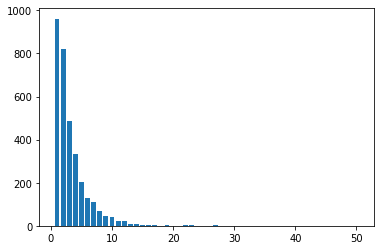

In [308]:
plt.bar(word_count.keys(), word_count.values())
plt.show()

## 刪除低頻字

In [309]:
word_counts = len([word for doc in doc_clean for word in doc])

In [310]:
word_count_dict = {}
for idx, doc in enumerate(doc_clean):
    for word in doc:
        if word not in word_count_dict.keys():
            word_count_dict[word] = 1/word_counts
        else:
            word_count_dict[word] += 1/word_counts

In [311]:
min_df = 0.001
doc_clean = [[word for word in doc if word_count_dict[word] >= min_df] for doc in doc_clean]

## 文本至少兩個字詞

In [312]:
doc_clean = [doc for doc in doc_clean if len(doc) > 1]

In [313]:
print('final len: ', len(doc_clean))

final len:  1598


## LDA

In [314]:
lda_dict = corpora.Dictionary(doc_clean)

In [315]:
doc_term_matrix = [lda_dict.doc2bow(doc) for doc in doc_clean]

In [316]:
doc_term_matrix[0]

[(0, 1), (1, 1)]

In [317]:
Lda = models.ldamodel.LdaModel

In [318]:
scores = []
n_topics = []

for n in range(0,10):
    ldamodel = Lda(doc_term_matrix, num_topics=n+1, id2word = lda_dict, passes=100, random_state= 42)
    cm = CoherenceModel(model=ldamodel, corpus=doc_term_matrix, coherence='u_mass')
    coherence = cm.get_coherence() 
    scores.append(coherence)
    n_topics.append(n+1)

In [319]:
for score, n in zip(scores, n_topics):
    print(score, n)

-6.7398971264669925 1
-10.295960217074391 2
-11.424265206456957 3
-13.149093532805956 4
-13.315057543512273 5
-14.031627208340849 6
-14.138360219086518 7
-14.61659671273781 8
-15.225402171777448 9
-15.125487231457441 10


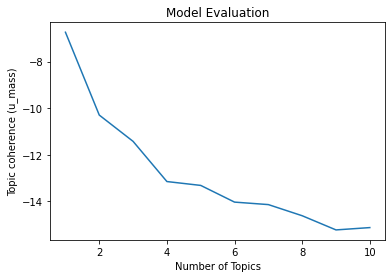

In [333]:
plt.plot(n_topics, scores)
plt.xlabel('Number of Topics')
plt.ylabel('Topic coherence (u_mass)')
plt.title('Model Evaluation')
plt.show()

In [320]:
best_n_topic = n_topics[np.argmin(scores)]

In [345]:
# select_n = best_n_topic
select_n = 7

In [346]:
ldamodel = Lda(doc_term_matrix, num_topics=select_n, id2word = lda_dict, passes=100, random_state= 42)

In [347]:
for out in ldamodel.print_topics(num_topics=select_n, num_words=5):
    print(out,'\n')

(0, '0.104*"教學" + 0.075*"資料" + 0.070*"觀念" + 0.049*"方面" + 0.048*"例子"') 

(1, '0.122*"知識" + 0.107*"影片" + 0.091*"教學" + 0.058*"理論" + 0.054*"課本"') 

(2, '0.250*"時間" + 0.248*"問題" + 0.053*"教學" + 0.045*"考試" + 0.041*"成績"') 

(3, '0.376*"課程" + 0.047*"能力" + 0.042*"授課" + 0.023*"想法" + 0.022*"互動"') 

(4, '0.238*"報告" + 0.195*"作業" + 0.129*"助教" + 0.039*"分組" + 0.037*"回饋"') 

(5, '0.081*"重點" + 0.079*"收穫" + 0.078*"講義" + 0.058*"進度" + 0.052*"系統"') 

(6, '0.191*"教學" + 0.145*"考試" + 0.064*"題目" + 0.049*"分數" + 0.046*"作業"') 



In [348]:
cm = CoherenceModel(model=ldamodel, corpus=doc_term_matrix, coherence='u_mass')
# cm = CoherenceModel(model=ldamodel, corpus=doc_term_matrix, coherence='c_v')
coherence = cm.get_coherence()  # get coherence value
print(coherence)

-14.138360219086518


-----

# Topic model evaluation 

In [349]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [350]:
ldamodel.show_topics()

[(0,
  '0.104*"教學" + 0.075*"資料" + 0.070*"觀念" + 0.049*"方面" + 0.048*"例子" + 0.046*"小考" + 0.040*"熱忱" + 0.037*"方向" + 0.035*"備課" + 0.029*"文本"'),
 (1,
  '0.122*"知識" + 0.107*"影片" + 0.091*"教學" + 0.058*"理論" + 0.054*"課本" + 0.049*"教材" + 0.044*"機會" + 0.036*"疫情" + 0.032*"難度" + 0.031*"幫助"'),
 (2,
  '0.250*"時間" + 0.248*"問題" + 0.053*"教學" + 0.045*"考試" + 0.041*"成績" + 0.035*"範圍" + 0.030*"發問" + 0.028*"期中考" + 0.019*"耐心" + 0.016*"講話"'),
 (3,
  '0.376*"課程" + 0.047*"能力" + 0.042*"授課" + 0.023*"想法" + 0.022*"互動" + 0.021*"講課" + 0.020*"技巧" + 0.019*"動作" + 0.019*"進度" + 0.018*"英文"'),
 (4,
  '0.238*"報告" + 0.195*"作業" + 0.129*"助教" + 0.039*"分組" + 0.037*"回饋" + 0.030*"邏輯" + 0.023*"要求" + 0.022*"期末考" + 0.020*"主題" + 0.018*"意見"'),
 (5,
  '0.081*"重點" + 0.079*"收穫" + 0.078*"講義" + 0.058*"進度" + 0.052*"系統" + 0.050*"舉例" + 0.048*"態度" + 0.048*"考卷" + 0.045*"概念" + 0.041*"速度"'),
 (6,
  '0.191*"教學" + 0.145*"考試" + 0.064*"題目" + 0.049*"分數" + 0.046*"作業" + 0.041*"評分" + 0.033*"進度" + 0.032*"答案" + 0.030*"標準" + 0.026*"反應"')]

In [351]:
graph = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, lda_dict)

In [352]:
graph

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.129196 -0.071180       1        1  17.024468
3     -0.151696  0.089864       2        1  16.088077
2      0.305926 -0.014848       3        1  15.170168
1     -0.028174 -0.175332       4        1  13.964256
4      0.051482  0.337463       5        1  13.268892
5     -0.247673  0.025157       6        1  12.369480
0     -0.059061 -0.191124       7        1  12.114660, topic_info=    Term        Freq       Total Category  logprob  loglift
21    課程  317.000000  317.000000  Default  30.0000  30.0000
36    時間  199.000000  199.000000  Default  29.0000  29.0000
56    問題  197.000000  197.000000  Default  28.0000  28.0000
16    報告  166.000000  166.000000  Default  27.0000  27.0000
22    作業  177.000000  177.000000  Default  26.0000  26.0000
..   ...         ...         ...      ...      ...      ...
72    經驗    9.906504   32.468813   Topic7  -4.1607   0.9237
108   意見    8.738131   30.701950   Topic7  -4.2862   0.8541
2     教學   65.843490  345.098426   Topic7  -2.2666   0.4542
131   興趣    5.835530   21.616106   Topic7  -4.6899   0.8013
11    進度   15.224940   99.229516   Topic7  -3.7310   0.2363

[263 rows x 6 columns], token_table=      Topic      Freq Term
term                      
100       3  0.513027   上台
100       4  0.093278   上台
100       5  0.373111   上台
133       2  0.914045   中文
39        2  0.357242   主題
...     ...       ...  ...
14        4  0.183197   題目
119       1  0.758346   額外
119       6  0.175003   額外
125       6  0.332113   黑板
125       7  0.553522   黑板

[319 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 4, 3, 2, 5, 6, 1])

In [353]:
pyLDAvis.save_html(graph, 'lda_final_all.html')

---